## Matched-filter signal detection with EQcorrscan

In [1]:
# set up logging
import logging

logging.basicConfig(
    level=logging.DEBUG,
    format="%(asctime)s\t%(name)s\t%(levelname)s\t%(message)s")

In [2]:
# build catalog of events to use as templates

%matplotlib inline
from obspy import UTCDateTime, Stream, read, read_events
from eqcorrscan.utils.catalog_utils import filter_picks

# create HYPODD format file with template events to import them into EQcorrscan
# entries are: #, YR, MO, DY, HR, MN, SC, LAT, LON, DEP, MAG, EH, EZ, RMS, ID 
#              followed by lines of observations: STA, TT, WGHT, PHA
# as specified here: https://www.ldeo.columbia.edu/~felixw/papers/Waldhauser_OFR2001.pdf
templates = ["# 2016  9 26  9 25 49.00  61.8000 -144.0000  30.00  1.00  0.0  0.0  0.00  1\n",
             "WASW    0.000  1       P\n",
             "MCR3    3.000  1       P\n",
             "N25K    3.500  1       P\n"]
# templates start on the times listed and span 14 seconds, locations are made up

# now write to file
with open("templates.pha", "w") as file:
    for line in templates:
        file.write(line)

# read the file into an Obspy catalog
catalog = read_events("templates.pha", format="HYPODDPHA")
# complete missing catalog info (required by EQcorrscan)
station_dict = {"WASW": {"network": "AV", "channel": "SHZ"},
                "MCR3": {"network": "YG", "channel": "BHZ"},
                "N25K": {"network": "TA", "channel": "BHZ"}}
for event in catalog.events:
    for pick in event.picks:
        if pick.waveform_id.station_code in station_dict:
            pick.waveform_id.network_code = station_dict[pick.waveform_id.station_code]["network"]
            pick.waveform_id.channel_code = station_dict[pick.waveform_id.station_code]["channel"]

# fig = catalog.plot(projection="local", resolution="h")

# inspect the contents
catalog[0].picks

2021-07-07 18:27:43,766	matplotlib	DEBUG	matplotlib data path: /Users/human/opt/anaconda3/envs/eqcorrscan/lib/python3.8/site-packages/matplotlib/mpl-data
2021-07-07 18:27:43,771	matplotlib	DEBUG	CONFIGDIR=/Users/human/.matplotlib
2021-07-07 18:27:43,773	matplotlib	DEBUG	matplotlib version 3.4.2
2021-07-07 18:27:43,774	matplotlib	DEBUG	interactive is False
2021-07-07 18:27:43,774	matplotlib	DEBUG	platform is darwin
2021-07-07 18:27:43,775	matplotlib	DEBUG	loaded modules: ['sys', 'builtins', '_frozen_importlib', '_imp', '_warnings', '_io', 'marshal', 'posix', '_frozen_importlib_external', '_thread', '_weakref', 'time', 'zipimport', '_codecs', 'codecs', 'encodings.aliases', 'encodings', 'encodings.utf_8', '_signal', '__main__', 'encodings.latin_1', '_abc', 'abc', 'io', '_stat', 'stat', '_collections_abc', 'genericpath', 'posixpath', 'os.path', 'os', '_sitebuiltins', '_locale', '_bootlocale', 'types', 'importlib._bootstrap', 'importlib._bootstrap_external', 'warnings', 'importlib', 'import

[Pick
	 resource_id: ResourceIdentifier(id="smi:local/dbd11d85-9040-46b3-b37a-ba89ef551f99")
	        time: UTCDateTime(2016, 9, 26, 9, 25, 49)
	 waveform_id: WaveformStreamID(network_code='AV', station_code='WASW', channel_code='SHZ', location_code='')
	  phase_hint: 'P',
 Pick
	 resource_id: ResourceIdentifier(id="smi:local/a5f2ae1b-0456-4f51-8a58-60ea702be927")
	        time: UTCDateTime(2016, 9, 26, 9, 25, 52)
	 waveform_id: WaveformStreamID(network_code='YG', station_code='MCR3', channel_code='BHZ', location_code='')
	  phase_hint: 'P',
 Pick
	 resource_id: ResourceIdentifier(id="smi:local/636af0f8-a1af-4626-8463-f5ac900f737f")
	        time: UTCDateTime(2016, 9, 26, 9, 25, 52, 500000)
	 waveform_id: WaveformStreamID(network_code='TA', station_code='N25K', channel_code='BHZ', location_code='')
	  phase_hint: 'P']

In [3]:
# load templates from local data and catalog generated in above cell

from eqcorrscan import Tribe

# build stream of data from local files (use same length files as desired for detection)
files = ["./subset_stations/AV.WASW.SHZ.2016-09-26.ms",
         "./subset_stations/YG.MCR3.BHZ.2016-09-26.ms",
         "./subset_stations/TA.N25K.BHZ.2016-09-26.ms"]
st = Stream()
for file in files: 
    st += read(file)

tribe = Tribe().construct(
    method="from_meta_file", meta_file=catalog, st=st, lowcut=1.0, highcut=10.0, 
    samp_rate=40.0, length=14.0, filt_order=4, prepick=0.5, swin='all',
    process_len=86400, parallel=True) # min_snr=5.0, 
print(tribe)

2021-07-07 18:27:52,538	eqcorrscan.core.template_gen	INFO	Pre-processing data
2021-07-07 18:27:55,006	eqcorrscan.core.template_gen	DEBUG	I have found the following picks
2021-07-07 18:27:55,007	eqcorrscan.core.template_gen	DEBUG	Pick
	 resource_id: ResourceIdentifier(id="smi:local/dbd11d85-9040-46b3-b37a-ba89ef551f99")
	        time: UTCDateTime(2016, 9, 26, 9, 25, 49)
	 waveform_id: WaveformStreamID(network_code='AV', station_code='WASW', channel_code='SHZ', location_code='')
	  phase_hint: 'P'
2021-07-07 18:27:55,007	eqcorrscan.core.template_gen	DEBUG	Pick
	 resource_id: ResourceIdentifier(id="smi:local/a5f2ae1b-0456-4f51-8a58-60ea702be927")
	        time: UTCDateTime(2016, 9, 26, 9, 25, 52)
	 waveform_id: WaveformStreamID(network_code='YG', station_code='MCR3', channel_code='BHZ', location_code='')
	  phase_hint: 'P'
2021-07-07 18:27:55,008	eqcorrscan.core.template_gen	DEBUG	Pick
	 resource_id: ResourceIdentifier(id="smi:local/636af0f8-a1af-4626-8463-f5ac900f737f")
	        time: UT

Tribe of 1 templates


2021-07-07 18:27:58,369	matplotlib.axes._base	DEBUG	top of axes not in the figure, so title not moved
2021-07-07 18:27:58,375	matplotlib.font_manager	DEBUG	findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=8.33.
2021-07-07 18:27:58,375	matplotlib.font_manager	DEBUG	findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Italic.ttf) italic normal 400 normal>) = 11.05
2021-07-07 18:27:58,376	matplotlib.font_manager	DEBUG	findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-BoldItalic.ttf) italic normal 700 normal>) = 11.335
2021-07-07 18:27:58,376	matplotlib.font_manager	DEBUG	findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymReg.ttf) normal normal 400 normal>) = 10.05
2021-07-07 18:27:58,377	matplotlib.font_manager	DEBUG	findfont: score(<Font 'cmsy10' (cmsy10.ttf) normal normal 400 normal>) = 10.05
2021-07-07 18:27:58,377	matplotlib.font_manager	DEBUG	findfont: score(<Font 'STIXNonUnicode' (STIXNonUniBolIta.ttf) italic normal 700 normal>) = 11.335


Template 2016_09_26t09_25_48: 
	 3 channels;
	 lowcut: 1.0 Hz;
	 highcut: 10.0 Hz;
	 sampling rate 40.0 Hz;
	 filter order: 4; 
	 process length: 86400.0 s


2021-07-07 18:27:58,477	matplotlib.font_manager	DEBUG	findfont: score(<Font 'Estrangelo Quenneshrin' (SyrCOMQenNeshrin.otf) normal normal 400 normal>) = 10.05
2021-07-07 18:27:58,477	matplotlib.font_manager	DEBUG	findfont: score(<Font 'Bitstream Vera Sans' (VeraBI.ttf) oblique normal 700 normal>) = 2.244090909090909
2021-07-07 18:27:58,478	matplotlib.font_manager	DEBUG	findfont: score(<Font '.SF Compact Text' (SFCompactText-Bold.otf) normal normal 700 normal>) = 10.335
2021-07-07 18:27:58,478	matplotlib.font_manager	DEBUG	findfont: score(<Font '.SF NS Symbols' (SFNSSymbols-Medium.otf) normal normal 500 normal>) = 10.145
2021-07-07 18:27:58,479	matplotlib.font_manager	DEBUG	findfont: score(<Font 'Latin Modern Roman Dunhill' (lmromandunh10-regular.otf) normal normal 400 normal>) = 10.05
2021-07-07 18:27:58,479	matplotlib.font_manager	DEBUG	findfont: score(<Font 'Luxi Sans' (luxisri.ttf) oblique normal 400 normal>) = 11.05
2021-07-07 18:27:58,480	matplotlib.font_manager	DEBUG	findfont: sc

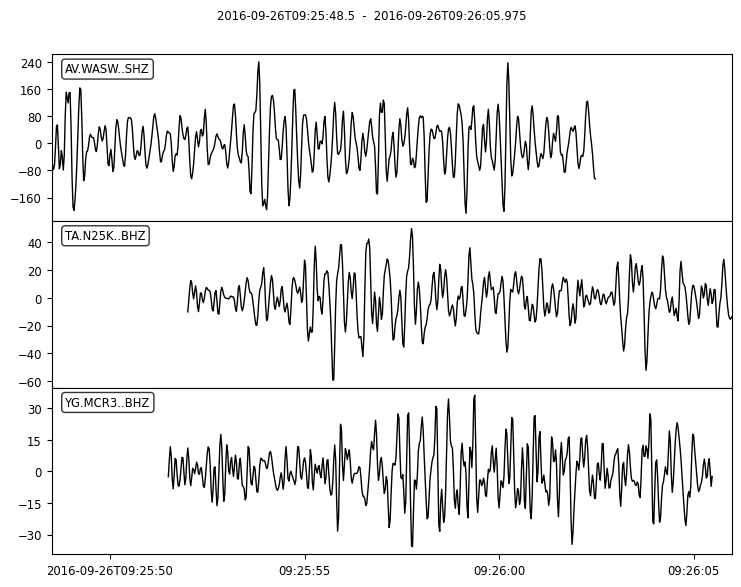

In [4]:
# inspect first template
print(tribe[0])
fig = tribe[0].st.plot(equal_scale=False, size=(800, 600))

In [5]:
# use tribe to detect events in local data

import glob

# build stream of all stations for detection
files_path = "./subset_stations"
doi = UTCDateTime("2016-09-26T00:00:00.0Z")
day_file_list = glob.glob(f"{files_path}/*.{doi.year}-{doi.month:02}"
							  f"-{doi.day:02}.ms")
# load files into stream
st = Stream()
for file in day_file_list:
    st += read(file)

# file = day_file_list[0]
# st += read(file)
# file = day_file_list[1]
# st += read(file)
# file = day_file_list[2]
# st += read(file)

# detect
party, st = tribe.detect(stream=st, threshold=9.0, daylong=True, threshold_type="MAD", trig_int=4.0,
                         plot=False, return_stream=True, parallel_process=True)

2021-07-07 18:28:21,880	eqcorrscan.core.match_filter.matched_filter	INFO	Splitting these data in 1 chunks
2021-07-07 18:28:21,895	eqcorrscan.core.match_filter.matched_filter	DEBUG	Processing chunk 0 between 2016-09-26T00:00:00.000000Z and 2016-09-27T00:00:00.000000Z
2021-07-07 18:28:21,907	eqcorrscan.core.match_filter.matched_filter	DEBUG	Processing chunk:
3 Trace(s) in Stream:
YG.MCR3..BHZ | 2016-09-26T00:00:00.000004Z - 2016-09-26T23:59:59.980004Z | 50.0 Hz, 4320000 samples
TA.N25K..BHZ | 2016-09-26T00:00:00.000000Z - 2016-09-26T23:59:59.975000Z | 40.0 Hz, 3456000 samples
AV.WASW..SHZ | 2016-09-26T00:00:00.000000Z - 2016-09-26T23:59:59.980000Z | 50.0 Hz, 4320000 samples
2021-07-07 18:28:24,634	eqcorrscan.core.match_filter.matched_filter	DEBUG	Processed stream:
3 Trace(s) in Stream:
YG.MCR3..BHZ | 2016-09-26T00:00:00.000004Z - 2016-09-26T23:59:59.975004Z | 40.0 Hz, 3456000 samples
TA.N25K..BHZ | 2016-09-26T00:00:00.000000Z - 2016-09-26T23:59:59.975000Z | 40.0 Hz, 3456000 samples
AV.WA

ValueError: not enough values to unpack (expected 2, got 1)

2021-07-07 18:28:41,338	matplotlib.axes._base	DEBUG	top of axes not in the figure, so title not moved
2021-07-07 18:28:41,355	matplotlib.axes._base	DEBUG	top of axes not in the figure, so title not moved
2021-07-07 18:28:41,392	matplotlib.axes._base	DEBUG	top of axes not in the figure, so title not moved
2021-07-07 18:28:41,402	matplotlib.axes._base	DEBUG	top of axes not in the figure, so title not moved
2021-07-07 18:28:41,427	matplotlib.axes._base	DEBUG	top of axes not in the figure, so title not moved
2021-07-07 18:28:41,437	matplotlib.axes._base	DEBUG	top of axes not in the figure, so title not moved
2021-07-07 18:28:41,474	matplotlib.axes._base	DEBUG	top of axes not in the figure, so title not moved
2021-07-07 18:28:41,484	matplotlib.axes._base	DEBUG	top of axes not in the figure, so title not moved
2021-07-07 18:28:41,498	matplotlib.axes._base	DEBUG	top of axes not in the figure, so title not moved
2021-07-07 18:28:41,515	matplotlib.axes._base	DEBUG	top of axes not in the figure,

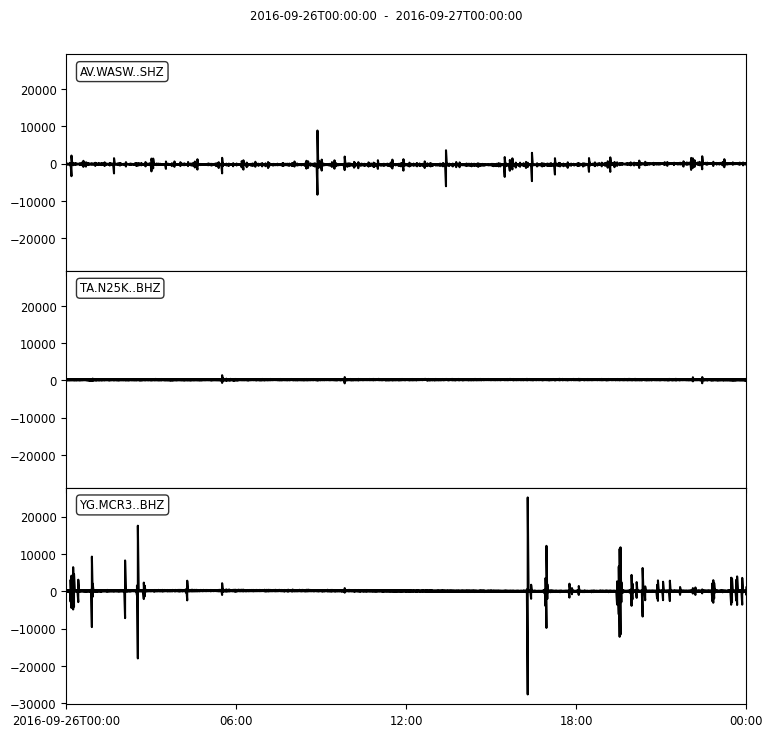

2021-07-07 18:28:41,574	matplotlib.axes._base	DEBUG	top of axes not in the figure, so title not moved
2021-07-07 18:28:41,588	matplotlib.axes._base	DEBUG	top of axes not in the figure, so title not moved
2021-07-07 18:28:41,617	matplotlib.axes._base	DEBUG	top of axes not in the figure, so title not moved
2021-07-07 18:28:41,627	matplotlib.axes._base	DEBUG	top of axes not in the figure, so title not moved
2021-07-07 18:28:41,663	matplotlib.axes._base	DEBUG	top of axes not in the figure, so title not moved
2021-07-07 18:28:41,672	matplotlib.axes._base	DEBUG	top of axes not in the figure, so title not moved
2021-07-07 18:28:41,687	matplotlib.axes._base	DEBUG	top of axes not in the figure, so title not moved
2021-07-07 18:28:41,704	matplotlib.axes._base	DEBUG	top of axes not in the figure, so title not moved


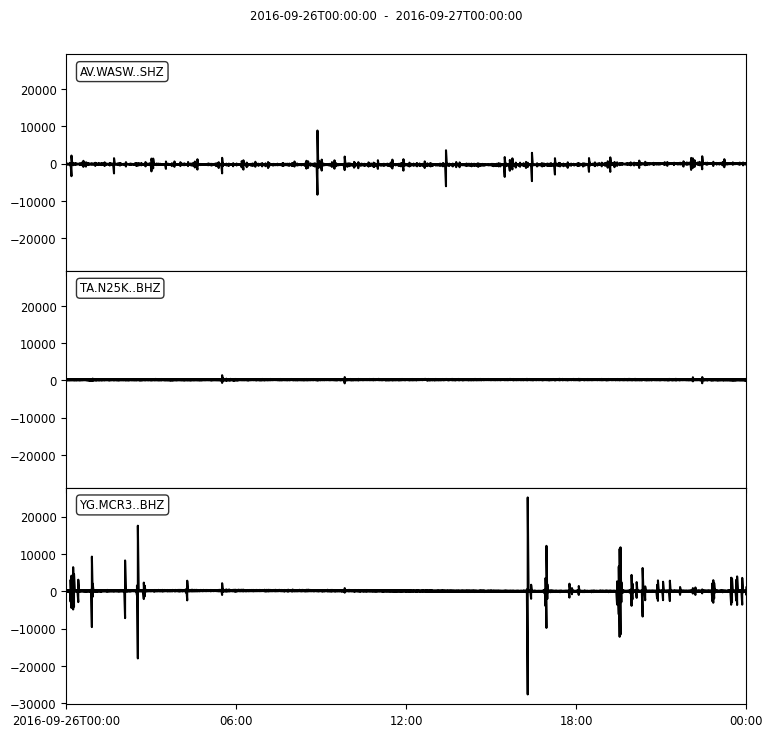

In [6]:
st.plot()


# From here down is not yet updated (from Client tutorial)

This will:

1. Download the data required;
2. Process the data in the same way as the templates in the `Tribe` (note that your
   tribe can contain templates processed in different ways: these will be grouped into
   similarly processed templates and the matched-filter process will be run multiple
   times; once for each group of similar templates);
3. Cross-correlate the templates with the processed data and stack the correlations;
4. Detect within each templates stacked cross-correlation array based on a given threshold;
5. Generate `Detection` objects with Obspy events and meta-data
    
Again, we used a few arguments here:

- `client`: This again is the client from which to download data;
- `starttime`: The start of the data we want to detect within;
- `endtime`: The end of the data we want to detect within;
- `threshold`: The threshold for detection: note that the correlation sum is both
  positive and negative valued.  Detections are made based on the absolute of the
  correlation vector, so both postively and negatively correlated detections are made;
- `threshold_type`: The type of threshold to use, in this case we used `"MAD"`, the
  median absolute deviation, our `threshold` is the MAD multiplier;
- `trig_int`: The minimum time (in seconds) between triggers.  The highest absolute
  correlation value will be used within this window if multiple possible triggers
  occur.  Note that this only applies within the detections from one template.
- `plotvar`: We turned plotting off in this case;
- `return_stream`: Setting this to `True` will return the pre-processed stream downloaded
  from the client, allowing us to reuse this stream for later processing.
      
Lets have a look at the cumulative detections we made.

In [ ]:
fig = party.plot(plot_grouped=True)

We were returned a `Party` and a `Stream`.  The `Party` is a container for `Family` objects. Each
`Family` contains a `Template` and all the detections associated with that `Template`.  Detections
are stored as `Detection` objects.

Lets have a look at the most productive family:

In [ ]:
family = sorted(party.families, key=lambda f: len(f))[-1]
print(family)

In [ ]:
fig = family.template.st.plot(equal_scale=False, size=(800, 600))

We can get a dictionary of streams for each detection in a `Family` and look at some of those:

In [ ]:
streams = family.extract_streams(stream=st, length=10, prepick=2.5)
print(family.detections[0])
fig = streams[family.detections[0].id].plot(equal_scale=False, size=(800, 600))

On some stations we can clearly see the earthquake that was detected. Remember that these data have not been filtered.

We can also undertake cross-correlation phase-picking using our templates.  This is achieved
using the `lag_calc` method on `Party` or `Family` objects.  You can also use the
`eqcorrscan.core.lag_calc` module directly on other catalogs.

We need to provide a merged stream to the lag-calc function. The stream we have obtained
from `tribe.detect` has overlaps in it. Using `stream.merge()` would result in gaps at those
overlaps, which we do not want. We use `stream.merge(method=1)` to take include the real data
in that gap.

In [ ]:
st = st.merge(method=1)
repicked_catalog = party.lag_calc(st, pre_processed=False, shift_len=0.5, min_cc=0.4)

This returns a catalog with picks for each detected event.  The arguments we have used are:

- The stream that we downloaded previously;
- `pre_processed`: Our data have not been processed, so we rely on `lag_calc` to process
  our data - this means that our data will be processed in the same way as our templates were;
- `shift_len`: This is the maximum allowed shift (positive and negative) of the pick-time 
  relative to the template moveout in seconds.
- `min_cc`: The minimum normalised cross-correlation value required to generate a pick. Picks
  are made on the maximum correlation within a window.
  
Lets look at one of the events that we have picked.  The correlation value for the pick is
stored in a comment:

In [ ]:
print(repicked_catalog[100].picks[0])

In [ ]:
print(repicked_catalog[100].picks[0].comments[0])

## Note:

Using long templates like this that include both P and S energy does not usually produce good
correlation derived phase arrivals.  This is simply a demonstration.  You should carefully select
your template length, and ideally include both P and S picks in the catalog that you use to
make templates.

Explore the rest of the tutorials and API docs for further hints.
